# Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import cv2
import nltk
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import gensim.downloader as api


# Load Dataset

In [2]:
df = pd.read_csv('cuisine.csv')
df

,name,image_url,description,cuisine,course,diet,prep_time,ingredients,instructions,image_available
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,https://www.archanaskitchen.com/images/archana...,Doddapatre Tambuli Recipe is a popular healing...,Indian,Side Dish,Vegetarian,Total in 30 M,\n\n\t\t\t\t\t\t\t \t\t4 cups Indian borage (D...,"To begin making the Doddapatre Tambuli, first ...",1
1,Fish Tandoori Recipe,https://www.archanaskitchen.com/images/archana...,Have you ever tried out fish tandoori? Trust m...,North Indian Recipes,Appetizer,High Protein Non Vegetarian,Total in 80 M,\n\n\t\t\t\t\t\t\t \t\t1 Fish\t\t\t\t\t\t\t \t...,"To begin making the Fish Tandoori recipe, keep...",1
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,https://www.archanaskitchen.com/images/archana...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,North Indian Recipes,Main Course,No Onion No Garlic (Sattvic),Total in 55 M,\n\n\t\t\t\t\t\t\t \t\t300 grams Colocasia roo...,To begin making the Arbi Shimla Mirch Sabzi Re...,1
3,Ambur Style Brinjal Curry Recipe,https://www.archanaskitchen.com/images/archana...,Brinjal Curry is prepared in different ways in...,Indian,Lunch,Vegetarian,Total in 20 M,\n\n\t\t\t\t\t\t\t \t\t5 Brinjal (Baingan / Eg...,To begin making the Ambur Style Brinjal Curry ...,1
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,https://www.archanaskitchen.com/images/archana...,Mangalorean Mavinakayi Menasinakai Curry Recip...,Mangalorean,Side Dish,Vegetarian,Total in 35 M,\n\n\t\t\t\t\t\t\t \t\t1 cup Mango (Raw)\t\t\t...,To begin making Mangalorean Mavinakayi Menasin...,1
...,...,...,...,...,...,...,...,...,...,...
4461,Tamil Nadu Style Vazha Thandu Thogayal Recipe ...,https://www.archanaskitchen.com/images/archana...,Tamil Nadu Style Vazha Thandu Thogayal Recipe ...,Tamil Nadu,Side Dish,Vegetarian,Total in 40 M,\n\n\t\t\t\t\t\t\t \t\t1 teaspoon Mustard seed...,We begin making the Tamil Nadu Style Vazha Tha...,1
4462,Kondakadalai Vazhathandu Puli Thengai Kuzhambu...,https://www.archanaskitchen.com/images/archana...,Kondakadalai Vazhathandu Puli Thengai Kuzhambu...,Tamil Nadu,Main Course,Diabetic Friendly,Total in 530 M,\n\n\t\t\t\t\t\t\t \t\t1 cup Kala Chana (Brown...,We begin making the Kondakadalai Vazhathandu P...,1
4463,Besan & Atta Ki Roti Recipe (Chickpea Flatbread),https://www.archanaskitchen.com/images/archana...,The Besan & Atta Ki Roti Recipe is a delicious...,Indian,Dinner,Vegetarian,Total in 40 M,\n\n\t\t\t\t\t\t\t \t\t2 cups Gram flour (besa...,To begin making the Besan & Atta Ki Roti Recip...,1
4464,Cauliflower And Methi Paratha Recipe,https://www.archanaskitchen.com/images/archana...,Cauliflower And Methi Paratha is a perfect bre...,Indian,Indian Breakfast,Vegetarian,Total in 60 M,\nFor the dough\n\n\t\t\t\t\t\t\t \t\t1 cup Wh...,To begin with Cauliflower And Methi Paratha Re...,1


In [3]:
df['ingredients']

0       \n\n\t\t\t\t\t\t\t \t\t4 cups Indian borage (D...
1       \n\n\t\t\t\t\t\t\t \t\t1 Fish\t\t\t\t\t\t\t \t...
2       \n\n\t\t\t\t\t\t\t \t\t300 grams Colocasia roo...
3       \n\n\t\t\t\t\t\t\t \t\t5 Brinjal (Baingan / Eg...
4       \n\n\t\t\t\t\t\t\t \t\t1 cup Mango (Raw)\t\t\t...
                              ...                        
4461    \n\n\t\t\t\t\t\t\t \t\t1 teaspoon Mustard seed...
4462    \n\n\t\t\t\t\t\t\t \t\t1 cup Kala Chana (Brown...
4463    \n\n\t\t\t\t\t\t\t \t\t2 cups Gram flour (besa...
4464    \nFor the dough\n\n\t\t\t\t\t\t\t \t\t1 cup Wh...
4465    \n\n\t\t\t\t\t\t\t \t\t1 cup Pink Masoor Dal (...
Name: ingredients, Length: 4466, dtype: object

In [5]:
df1 = df.copy()

# The code splits each ingredient entry into lines, removes quantities, units, descriptive words, and special characters to isolate the core ingredient name. It then collects and counts these cleaned ingredient names across all entries to find their frequencies.

In [6]:
# Define regex to remove quantity + unit at the start
quantity_unit_pattern = r'^\s*(\d+\s*/\s*\d+|\d+\.\d+|\d+)?\s*(cup|cups|tablespoon|tablespoons|teaspoon|teaspoons|gram|grams|ounce|ounces|pound|pounds|pinch|pinches|dash|dashes|liter|liters|milliliter|milliliters|kg|kilogram|kilograms)?\s*'

# Words to remove like chopped, grated, sliced, fresh, etc.
remove_words = r'\b(chopped|grated|minced|diced|sliced|fresh|crushed|ground|peeled|optional|to taste|shredded|small|large|medium|and|or)\b'

# Pattern to remove all non-alphabetic characters
clean_pattern = r'[^a-zA-Z\s]'

def extract_ingredients(entry):
    lines = re.split(r'[\n\t\r]+', entry)  # split on newlines/tabs
    ingredients = []
    for line in lines:
        line = line.strip().lower()
        if line:
            line = re.sub(quantity_unit_pattern, '', line, flags=re.IGNORECASE)
            line = re.sub(remove_words, '', line, flags=re.IGNORECASE)
            line = re.sub(clean_pattern, '', line)
            line = line.split(',')[0].strip()
            if line:
                ingredients.append(line)
    return ingredients

# Extract all ingredients from df1['ingredients']
all_ingredients = []
for entry in df1['ingredients']:
    all_ingredients.extend(extract_ingredients(entry))

# Count frequency
ingredient_freq = Counter(all_ingredients)

# Sort by frequency
sorted_ingredients = sorted(ingredient_freq.items(), key=lambda x: x[1], reverse=True)

# Display results
for ingredient, freq in sorted_ingredients:
    print(f"{ingredient}: {freq}")

salt: 3150
finely: 2608
turmeric powder haldi: 1847
oil: 1541
cumin seeds jeera: 1240
red chilli powder: 1217
mustard seeds rai kadugu: 1123
onion: 1077
green chillies: 1013
cloves garlic: 865
inch ginger: 848
sprig curry leaves: 778
asafoetida hing: 778
ghee: 758
coriander dhania leaves: 674
garam masala powder: 634
dry red chillies: 608
as required: 598
coriander powder dhania: 579
coconut: 541
green chilli: 497
water: 475
sugar: 457
tomatoes: 456
inch cinnamon stick dalchini: 444
cardamom elaichi podsseeds: 428
cloves laung: 420
tomato: 412
cumin powder jeera: 407
sprig coriander dhania leaves: 362
curd dahi  yogurt: 355
white urad dal split: 346
onions: 341
jaggery: 331
whole black peppercorns: 318
curry leaves: 316
bay leaf tej patta: 312
s oil: 307
slit: 301
methi seeds fenugreek seeds: 292
cardamom powder elaichi: 292
lemon juice: 272
cashew nuts: 272
dry red chilli: 267
fennel seeds saunf: 266
for cooking: 237
chana dal bengal gram dal: 231
roughly: 225
ginger: 222
black pepper

# Create new ingredient list

In [8]:
tqdm.pandas()  # Enable progress_apply for pandas

# Extract only the ingredient names from sorted_ingredients in an expanded way
ingredient_names = []
for ingredient_freq_tuple in sorted_ingredients:
    ingredient = ingredient_freq_tuple[0]  # Get the ingredient name
    ingredient_names.append(ingredient)   # Add it to the list

# Function to find all ingredient names present in a given entry
def find_ingredients_in_entry(entry):
    entry_lower = entry.lower()  # convert entry text to lowercase for case-insensitive matching
    matched_ingredients = []     # list to store matched ingredients
    
    for ingredient in ingredient_names:
        # Create a regex pattern with word boundaries to avoid partial matches
        pattern = r'\b' + re.escape(ingredient) + r'\b'
        
        # Search for the ingredient in the entry
        if re.search(pattern, entry_lower):
            matched_ingredients.append(ingredient)
            
    return matched_ingredients

# Apply the function to the 'ingredients' column of df1 and create a new column 'ingredient_list' with a progress bar
df1['ingredient_list'] = df1['ingredients'].progress_apply(find_ingredients_in_entry)


100%|███████████████████████████████████████| 4466/4466 [20:52<00:00,  3.56it/s]


In [9]:
df1.head()

,name,image_url,description,cuisine,course,diet,prep_time,ingredients,instructions,image_available,ingredient_list
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,https://www.archanaskitchen.com/images/archana...,Doddapatre Tambuli Recipe is a popular healing...,Indian,Side Dish,Vegetarian,Total in 30 M,\n\n\t\t\t\t\t\t\t \t\t4 cups Indian borage (D...,"To begin making the Doddapatre Tambuli, first ...",1,"[salt, ghee, coconut, whole black peppercorns,..."
1,Fish Tandoori Recipe,https://www.archanaskitchen.com/images/archana...,Have you ever tried out fish tandoori? Trust m...,North Indian Recipes,Appetizer,High Protein Non Vegetarian,Total in 80 M,\n\n\t\t\t\t\t\t\t \t\t1 Fish\t\t\t\t\t\t\t \t...,"To begin making the Fish Tandoori recipe, keep...",1,"[salt, finely, oil, red chilli powder, green c..."
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,https://www.archanaskitchen.com/images/archana...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,North Indian Recipes,Main Course,No Onion No Garlic (Sattvic),Total in 55 M,\n\n\t\t\t\t\t\t\t \t\t300 grams Colocasia roo...,To begin making the Arbi Shimla Mirch Sabzi Re...,1,"[salt, oil, red chilli powder, inch ginger, ga..."
3,Ambur Style Brinjal Curry Recipe,https://www.archanaskitchen.com/images/archana...,Brinjal Curry is prepared in different ways in...,Indian,Lunch,Vegetarian,Total in 20 M,\n\n\t\t\t\t\t\t\t \t\t5 Brinjal (Baingan / Eg...,To begin making the Ambur Style Brinjal Curry ...,1,"[salt, oil, red chilli powder, onion, sprig cu..."
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,https://www.archanaskitchen.com/images/archana...,Mangalorean Mavinakayi Menasinakai Curry Recip...,Mangalorean,Side Dish,Vegetarian,Total in 35 M,\n\n\t\t\t\t\t\t\t \t\t1 cup Mango (Raw)\t\t\t...,To begin making Mangalorean Mavinakayi Menasin...,1,"[salt, oil, dry red chillies, coconut, water, ..."


In [10]:
from collections import Counter

# Flatten the list of lists
all_ingredients = [ingredient for sublist in df1['ingredient_list'] for ingredient in sublist]

# Count frequencies
ingredient_counts = Counter(all_ingredients)

# Convert to DataFrame (optional, for better display)
ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['ingredient', 'count'])

# Sort by frequency
ingredient_counts_df = ingredient_counts_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Display
print(ingredient_counts_df)


                      ingredient  count
0                       teaspoon   3107
1                           salt   3055
2                            cup   3022
3                         powder   2711
4                          taste   2531
...                          ...    ...
2790  for the roasted garlic dip      1
2791     for the kulcha stuffing      1
2792         julienned to straws      1
2793    veeba sweet chilli sauce      1
2794      for making the filling      1

[2795 rows x 2 columns]


# Model Building and testing

In [14]:
df1

,name,image_url,description,cuisine,course,diet,prep_time,ingredients,instructions,image_available,ingredient_list
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,https://www.archanaskitchen.com/images/archana...,Doddapatre Tambuli Recipe is a popular healing...,Indian,Side Dish,Vegetarian,Total in 30 M,\n\n\t\t\t\t\t\t\t \t\t4 cups Indian borage (D...,"To begin making the Doddapatre Tambuli, first ...",1,"[salt, ghee, coconut, whole black peppercorns,..."
1,Fish Tandoori Recipe,https://www.archanaskitchen.com/images/archana...,Have you ever tried out fish tandoori? Trust m...,North Indian Recipes,Appetizer,High Protein Non Vegetarian,Total in 80 M,\n\n\t\t\t\t\t\t\t \t\t1 Fish\t\t\t\t\t\t\t \t...,"To begin making the Fish Tandoori recipe, keep...",1,"[salt, finely, oil, red chilli powder, green c..."
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,https://www.archanaskitchen.com/images/archana...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,North Indian Recipes,Main Course,No Onion No Garlic (Sattvic),Total in 55 M,\n\n\t\t\t\t\t\t\t \t\t300 grams Colocasia roo...,To begin making the Arbi Shimla Mirch Sabzi Re...,1,"[salt, oil, red chilli powder, inch ginger, ga..."
3,Ambur Style Brinjal Curry Recipe,https://www.archanaskitchen.com/images/archana...,Brinjal Curry is prepared in different ways in...,Indian,Lunch,Vegetarian,Total in 20 M,\n\n\t\t\t\t\t\t\t \t\t5 Brinjal (Baingan / Eg...,To begin making the Ambur Style Brinjal Curry ...,1,"[salt, oil, red chilli powder, onion, sprig cu..."
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,https://www.archanaskitchen.com/images/archana...,Mangalorean Mavinakayi Menasinakai Curry Recip...,Mangalorean,Side Dish,Vegetarian,Total in 35 M,\n\n\t\t\t\t\t\t\t \t\t1 cup Mango (Raw)\t\t\t...,To begin making Mangalorean Mavinakayi Menasin...,1,"[salt, oil, dry red chillies, coconut, water, ..."
...,...,...,...,...,...,...,...,...,...,...,...
4461,Tamil Nadu Style Vazha Thandu Thogayal Recipe ...,https://www.archanaskitchen.com/images/archana...,Tamil Nadu Style Vazha Thandu Thogayal Recipe ...,Tamil Nadu,Side Dish,Vegetarian,Total in 40 M,\n\n\t\t\t\t\t\t\t \t\t1 teaspoon Mustard seed...,We begin making the Tamil Nadu Style Vazha Tha...,1,"[salt, oil, sprig curry leaves, dry red chilli..."
4462,Kondakadalai Vazhathandu Puli Thengai Kuzhambu...,https://www.archanaskitchen.com/images/archana...,Kondakadalai Vazhathandu Puli Thengai Kuzhambu...,Tamil Nadu,Main Course,Diabetic Friendly,Total in 530 M,\n\n\t\t\t\t\t\t\t \t\t1 cup Kala Chana (Brown...,We begin making the Kondakadalai Vazhathandu P...,1,"[salt, oil, sprig curry leaves, coconut, water..."
4463,Besan & Atta Ki Roti Recipe (Chickpea Flatbread),https://www.archanaskitchen.com/images/archana...,The Besan & Atta Ki Roti Recipe is a delicious...,Indian,Dinner,Vegetarian,Total in 40 M,\n\n\t\t\t\t\t\t\t \t\t2 cups Gram flour (besa...,To begin making the Besan & Atta Ki Roti Recip...,1,"[salt, finely, oil, red chilli powder, onion, ..."
4464,Cauliflower And Methi Paratha Recipe,https://www.archanaskitchen.com/images/archana...,Cauliflower And Methi Paratha is a perfect bre...,Indian,Indian Breakfast,Vegetarian,Total in 60 M,\nFor the dough\n\n\t\t\t\t\t\t\t \t\t1 cup Wh...,To begin with Cauliflower And Methi Paratha Re...,1,"[salt, finely, oil, red chilli powder, onion, ..."


In [15]:
import pandas as pd
import networkx as nx
from typing import List, Tuple, Optional

# Standardize ingredients by converting to lowercase
def standardize_ingredients(ingredients: List[str]) -> List[str]:
    return [ing.lower() for ing in ingredients]

# Preprocess df1['ingredient_list'] to standardize ingredients
df1['ingredient_list'] = df1['ingredient_list'].apply(standardize_ingredients)

# Initialize knowledge graph
G = nx.Graph()

# Add nodes and edges to the graph
for idx, row in df1.iterrows():
    dish = row['name']
    ingredients = row['ingredient_list']
    G.add_node(dish, type='dish')
    for ing in ingredients:
        G.add_node(ing, type='ingredient')
        G.add_edge(dish, ing, type='used_in')

# Function to recommend dish based on user ingredients
def recommend_dish(user_ingredients: List[str], top_n: int = 1) -> List[Tuple[Optional[str], List[str], float]]:
    # Standardize user input
    user_ingredients = standardize_ingredients(user_ingredients)
    user_ings_set = set(user_ingredients)
    scores = []
    
    # Score each dish
    for dish in [n for n, d in G.nodes(data=True) if d['type'] == 'dish']:
        dish_ings = [n for n in G.neighbors(dish) if G.nodes[n]['type'] == 'ingredient']
        dish_ings_set = set(dish_ings)
        intersection = user_ings_set & dish_ings_set
        union = user_ings_set | dish_ings_set
        if intersection:  # Only consider dishes with at least one match
            jaccard = len(intersection) / len(union) if union else 0
            # Store dish, matching ingredients, and score
            scores.append((dish, list(intersection), jaccard))
    
    # Sort by Jaccard score, then by number of ingredients (favor fewer for ties)
    scores.sort(key=lambda x: (x[2], -len([n for n in G.neighbors(x[0]) if G.nodes[n]['type'] == 'ingredient'])), reverse=True)
    
    # Return top_n results with debugging info
    if not scores:
        print("No matching dishes found for input:", user_ingredients)
        return [(None, [], 0.0)]
    for dish, matches, score in scores[:top_n]:
        print(f"Dish: {dish}, Matches: {matches}, Jaccard Score: {score:.3f}")
    return scores[:top_n]

# Example usage
# user_input = ['cauliflower', 'turmeric', 'ghee']  # Replace with your test ingredients
# results = recommend_dish(user_input)
# print("Top recommended dish:", results[0][0] if results[0][0] else "None")

In [30]:
user_input = ['cauliflower', 'turmeric', 'ghee']  # Replace with your test ingredients
results = recommend_dish(user_input)
print("Top recommended dish:", results[0][0] if results[0][0] else "None")

Top recommended dish: Coconut Jaggery Burfi Recipe 


In [17]:
import pickle

with open("dish_ingredient_graph_baseline_model.gpickle", "wb") as f:
    pickle.dump(G, f)



Evaluation Metrics Across 100 Dishes:
Average Jaccard Similarity: 0.1833
Average Fuzzy Accuracy: 0.2494
Average Word Matching Accuracy: 0.1327

Predicted Dishes for All 100 Entries:
| Original Dish     | Predicted Dish 1                                                                                                                                                                                                       | Predicted Dish 2                                                                                                                                                                                                       | Predicted Dish 3                                                                       |
|:------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------

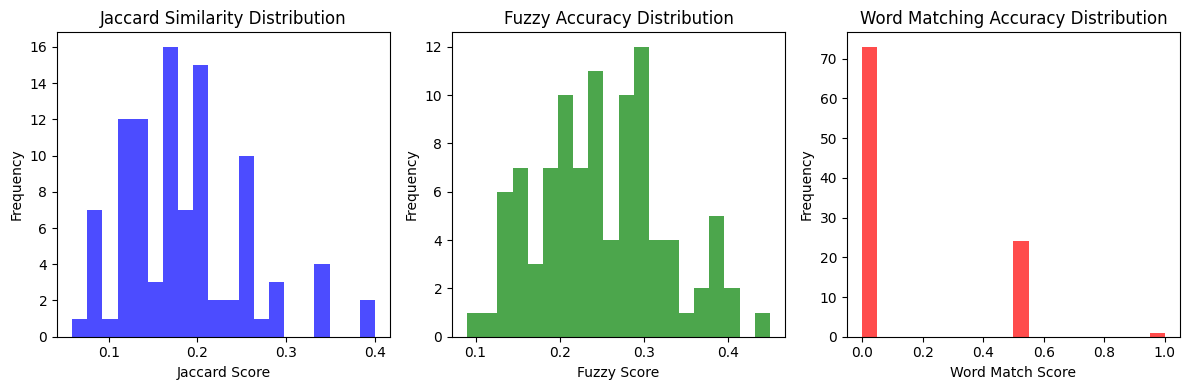

In [18]:
import pickle
import networkx as nx
from typing import List, Tuple, Optional
from fuzzywuzzy import fuzz
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved graph
with open("dish_ingredient_graph_baseline_model.gpickle", "rb") as f:
    G = pickle.load(f)

# Utility function to clean input
def standardize_ingredients(ingredients: List[str]) -> List[str]:
    return [ing.lower().strip() for ing in ingredients]

# Recommendation function to return top 3 dishes
def recommend_dish(user_ingredients: List[str], top_n: int = 3) -> List[Tuple[Optional[str], List[str], float]]:
    user_ingredients = standardize_ingredients(user_ingredients)
    user_ings_set = set(user_ingredients)
    scores = []

    for dish in [n for n, d in G.nodes(data=True) if d['type'] == 'dish']:
        dish_ings = [n for n in G.neighbors(dish) if G.nodes[n]['type'] == 'ingredient']
        dish_ings_set = set(dish_ings)
        intersection = user_ings_set & dish_ings_set
        union = user_ings_set | dish_ings_set
        if intersection:
            jaccard = len(intersection) / len(union)
            scores.append((dish, list(intersection), jaccard))

    scores.sort(key=lambda x: (x[2], -len([n for n in G.neighbors(x[0]) if G.nodes[n]['type'] == 'ingredient'])), reverse=True)

    if not scores:
        return [(None, [], 0.0)] * top_n

    return scores[:top_n]

# Word matching accuracy function
def word_matching_accuracy(pred_name: str, true_name: str) -> float:
    if pred_name is None:
        return 0.0
    pred_words = set(re.findall(r'\w+', pred_name.lower()))
    true_words = set(re.findall(r'\w+', true_name.lower()))
    if not true_words:
        return 0.0
    return len(pred_words.intersection(true_words)) / len(true_words)

# Evaluation function
def evaluate_model(dishes: List[dict]) -> Tuple[List[float], List[float], List[float], pd.DataFrame]:
    jaccard_scores = []
    fuzzy_scores = []
    word_match_scores = []
    results_data = []

    for dish in dishes:
        true_name = dish['name']
        ingredients = dish['ingredients']
        results = recommend_dish(ingredients, top_n=3)

        # Store prediction details
        pred_dishes = [pred_name if pred_name else "None" for pred_name, _, _ in results]
        results_data.append({
            "Original Dish": true_name,
            "Predicted Dish 1": pred_dishes[0],
            "Predicted Dish 2": pred_dishes[1],
            "Predicted Dish 3": pred_dishes[2]
        })

        # Compute metrics for the top 3 predictions
        best_jaccard = max([score for _, _, score in results], default=0.0)
        best_fuzzy = max([fuzz.ratio(true_name.lower(), pred_name.lower()) / 100 if pred_name else 0.0 for pred_name, _, _ in results])
        best_word_match = max([word_matching_accuracy(pred_name, true_name) if pred_name else 0.0 for pred_name, _, _ in results])

        jaccard_scores.append(best_jaccard)
        fuzzy_scores.append(best_fuzzy)
        word_match_scores.append(best_word_match)

    # Create DataFrame for results
    results_df = pd.DataFrame(results_data)

    return jaccard_scores, fuzzy_scores, word_match_scores, results_df

# Plotting function
def plot_metrics(jaccard_scores: List[float], fuzzy_scores: List[float], word_match_scores: List[float]):
    plt.figure(figsize=(12, 4))

    # Jaccard Similarity Distribution
    plt.subplot(1, 3, 1)
    plt.hist(jaccard_scores, bins=20, color='blue', alpha=0.7)
    plt.title('Jaccard Similarity Distribution')
    plt.xlabel('Jaccard Score')
    plt.ylabel('Frequency')

    # Fuzzy Accuracy Distribution
    plt.subplot(1, 3, 2)
    plt.hist(fuzzy_scores, bins=20, color='green', alpha=0.7)
    plt.title('Fuzzy Accuracy Distribution')
    plt.xlabel('Fuzzy Score')
    plt.ylabel('Frequency')

    # Word Matching Accuracy Distribution
    plt.subplot(1, 3, 3)
    plt.hist(word_match_scores, bins=20, color='red', alpha=0.7)
    plt.title('Word Matching Accuracy Distribution')
    plt.xlabel('Word Match Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Dataset
dishes = [
    {"name": "Aloo Gobi", "ingredients": ["potato", "cauliflower", "turmeric", "cumin", "ghee", "onion", "garlic", "ginger"]},
    {"name": "Butter Chicken", "ingredients": ["chicken", "butter", "tomato", "cream", "garam masala", "turmeric", "ginger", "garlic"]},
    {"name": "Palak Paneer", "ingredients": ["spinach", "paneer", "onion", "tomato", "garlic", "ginger", "cumin", "turmeric"]},
    {"name": "Chole Masala", "ingredients": ["chickpeas", "onion", "tomato", "ginger", "garlic", "cumin", "coriander", "turmeric"]},
    {"name": "Naan", "ingredients": ["flour", "yeast", "ghee", "yogurt", "salt", "sugar"]},
    {"name": "Chicken Biryani", "ingredients": ["rice", "chicken", "saffron", "cardamom", "cloves", "onion", "ghee", "turmeric"]},
    {"name": "Samosa", "ingredients": ["flour", "potato", "peas", "cumin", "turmeric", "ghee", "chili"]},
    {"name": "Masala Dosa", "ingredients": ["rice", "urad dal", "salt", "ghee", "potato", "onion"]},
    {"name": "Rasgulla", "ingredients": ["milk", "sugar", "cardamom", "lemon"]},
    {"name": "Rogan Josh", "ingredients": ["lamb", "yogurt", "garlic", "ginger", "cardamom", "cloves", "turmeric", "chili"]},
    {"name": "Dal Tadka", "ingredients": ["lentils", "ghee", "cumin", "garlic", "onion", "tomato", "turmeric", "chili"]},
    {"name": "Pani Puri", "ingredients": ["flour", "semolina", "potato", "chickpeas", "tamarind", "cumin", "chili"]},
    {"name": "Tandoori Chicken", "ingredients": ["chicken", "yogurt", "turmeric", "garam masala", "ginger", "garlic", "chili"]},
    {"name": "Malai Kofta", "ingredients": ["paneer", "potato", "cream", "tomato", "cashew", "turmeric", "ginger"]},
    {"name": "Idli Sambar", "ingredients": ["rice", "urad dal", "salt", "ghee", "lentils", "tamarind"]},
    {"name": "Gulab Jamun", "ingredients": ["milk powder", "flour", "sugar", "ghee", "cardamom"]},
    {"name": "Vada Pav", "ingredients": ["flour", "potato", "chili", "cumin", "turmeric", "ghee"]},
    {"name": "Pav Bhaji", "ingredients": ["potato", "tomato", "peas", "butter", "onion", "garam masala", "chili"]},
    {"name": "Rice Kheer", "ingredients": ["rice", "milk", "sugar", "cardamom", "saffron", "nuts"]},
    {"name": "Matar Paneer", "ingredients": ["paneer", "peas", "tomato", "onion", "turmeric", "ginger", "garlic"]},
    {"name": "Aloo Paratha", "ingredients": ["flour", "potato", "ghee", "cumin", "chili"]},
    {"name": "Chicken Tikka", "ingredients": ["chicken", "yogurt", "turmeric", "cumin", "ginger", "garlic", "chili"]},
    {"name": "Baingan Bharta", "ingredients": ["eggplant", "onion", "tomato", "garlic", "ginger", "cumin", "turmeric"]},
    {"name": "Jalebi", "ingredients": ["flour", "sugar", "saffron", "ghee"]},
    {"name": "Veg Pulao", "ingredients": ["rice", "peas", "carrot", "cloves", "cardamom", "ghee", "cumin"]},
    {"name": "Bhindi Masala", "ingredients": ["okra", "onion", "tomato", "turmeric", "cumin", "chili"]},
    {"name": "Kadai Chicken", "ingredients": ["chicken", "tomato", "onion", "capsicum", "ginger", "garlic", "turmeric"]},
    {"name": "Sev Puri", "ingredients": ["flour", "potato", "onion", "tamarind", "chili", "sev"]},
    {"name": "Mango Lassi", "ingredients": ["yogurt", "mango", "sugar", "cardamom"]},
    {"name": "Dhokla", "ingredients": ["gram flour", "yogurt", "turmeric", "mustard seeds", "ghee"]},
    {"name": "Mutton Curry", "ingredients": ["mutton", "onion", "tomato", "ginger", "garlic", "turmeric", "cloves"]},
    {"name": "Poori", "ingredients": ["flour", "ghee", "salt"]},
    {"name": "Shahi Paneer", "ingredients": ["paneer", "cream", "tomato", "cashew", "turmeric", "cardamom"]},
    {"name": "Kachori", "ingredients": ["flour", "lentils", "ghee", "cumin", "chili"]},
    {"name": "Aloo Tikki", "ingredients": ["potato", "peas", "cumin", "chili", "ghee"]},
    {"name": "Fish Curry", "ingredients": ["fish", "coconut", "tomato", "turmeric", "ginger", "garlic", "chili"]},
    {"name": "Upma", "ingredients": ["semolina", "mustard seeds", "onion", "ghee", "chili"]},
    {"name": "Misal Pav", "ingredients": ["sprouts", "onion", "tomato", "chili", "ghee", "pav"]},
    {"name": "Milk Barfi", "ingredients": ["milk", "sugar", "ghee", "cardamom"]},
    {"name": "Vegetable Korma", "ingredients": ["carrot", "peas", "potato", "cream", "cashew", "turmeric"]},
    {"name": "Papdi Chaat", "ingredients": ["flour", "milk", "potato", "yogurt", "tamarind", "chili"]},
    {"name": "Plain Paratha", "ingredients": ["flour", "ghee", "salt"]},
    {"name": "Prawn Masala", "ingredients": ["prawns", "onion", "tomato", "turmeric", "ginger", "garlic", "chili"]},
    {"name": "Kulfi", "ingredients": ["milk", "sugar", "cardamom", "nuts"]},
    {"name": "Methi Thepla", "ingredients": ["flour", "fenugreek", "turmeric", "ghee", "yogurt"]},
    {"name": "Dum Aloo", "ingredients": ["potato", "yogurt", "tomato", "turmeric", "ginger", "garlic"]},
    {"name": "Khichdi", "ingredients": ["rice", "lentils", "ghee", "cumin", "turmeric"]},
    {"name": "Sooji Halwa", "ingredients": ["semolina", "ghee", "sugar", "cardamom", "nuts"]},
    {"name": "Kadhi Pakora", "ingredients": ["yogurt", "gram flour", "turmeric", "cumin", "chili"]},
    {"name": "Chicken Korma", "ingredients": ["chicken", "yogurt", "cream", "cashew", "turmeric", "ginger"]},
    {"name": "Pesarattu", "ingredients": ["moong dal", "rice", "ghee", "onion"]},
    {"name": "Bhel Puri", "ingredients": ["puffed rice", "onion", "tomato", "tamarind", "chili"]},
    {"name": "Gobi Manchurian", "ingredients": ["cauliflower", "soy sauce", "ginger", "garlic", "turmeric"]},
    {"name": "Paneer Tikka", "ingredients": ["paneer", "yogurt", "turmeric", "cumin", "ginger", "garlic"]},
    {"name": "Cucumber Raita", "ingredients": ["yogurt", "cucumber", "cumin", "salt"]},
    {"name": "Keema Curry", "ingredients": ["minced meat", "onion", "tomato", "ginger", "garlic", "turmeric"]},
    {"name": "Appam", "ingredients": ["rice", "coconut", "yeast", "sugar"]},
    {"name": "Modak", "ingredients": ["rice flour", "coconut", "jaggery", "cardamom"]},
    {"name": "Aloo Methi", "ingredients": ["potato", "fenugreek", "turmeric", "cumin", "ghee"]},
    {"name": "Chicken Chettinad", "ingredients": ["chicken", "coconut", "turmeric", "ginger", "garlic", "chili"]},
    {"name": "Pongal", "ingredients": ["rice", "moong dal", "ghee", "cashew", "pepper"]},
    {"name": "Sandesh", "ingredients": ["paneer", "sugar", "cardamom"]},
    {"name": "Laal Maas", "ingredients": ["mutton", "chili", "garlic", "ginger", "yogurt", "turmeric"]},
    {"name": "Vegetable Biryani", "ingredients": ["rice", "carrot", "peas", "cloves", "cardamom", "ghee"]},
    {"name": "Uttapam", "ingredients": ["rice", "urad dal", "onion", "tomato", "ghee"]},
    {"name": "Mysore Pak", "ingredients": ["gram flour", "ghee", "sugar"]},
    {"name": "Aloo Posto", "ingredients": ["potato", "poppy seeds", "turmeric", "chili", "ghee"]},
    {"name": "Shrikhand", "ingredients": ["yogurt", "sugar", "cardamom", "saffron"]},
    {"name": "Beetroot Poriyal", "ingredients": ["beetroot", "coconut", "mustard seeds", "chili"]},
    {"name": "Mushroom Masala", "ingredients": ["mushroom", "onion", "tomato", "turmeric", "ginger"]},
    {"name": "Pindi Chana", "ingredients": ["chickpeas", "tea leaves", "turmeric", "ginger", "garlic"]},
    {"name": "Saffron Kesari", "ingredients": ["semolina", "ghee", "sugar", "saffron", "nuts"]},
    {"name": "Chicken 65", "ingredients": ["chicken", "yogurt", "chili", "ginger", "garlic"]},
    {"name": "Avial", "ingredients": ["carrot", "beans", "coconut", "yogurt", "turmeric"]},
    {"name": "Prawn Biryani", "ingredients": ["prawns", "rice", "cloves", "cardamom", "ghee"]},
    {"name": "Phirni", "ingredients": ["rice", "milk", "sugar", "cardamom"]},
    {"name": "Rajma Masala", "ingredients": ["kidney beans", "onion", "tomato", "ginger", "garlic", "turmeric"]},
    {"name": "Batata Vada", "ingredients": ["potato", "gram flour", "chili", "turmeric", "ghee"]},
    {"name": "Khandvi", "ingredients": ["gram flour", "yogurt", "turmeric", "mustard seeds"]},
    {"name": "Mutton Biryani", "ingredients": ["mutton", "rice", "saffron", "cloves", "ghee"]},
    {"name": "Sambar", "ingredients": ["lentils", "tamarind", "tomato", "turmeric", "mustard seeds"]},
    {"name": "Puran Poli", "ingredients": ["flour", "lentils", "jaggery", "cardamom", "ghee"]},
    {"name": "Aloo Baingan", "ingredients": ["potato", "eggplant", "tomato", "turmeric", "cumin"]},
    {"name": "Chakli", "ingredients": ["rice flour", "gram flour", "ghee", "cumin"]},
    {"name": "Saag Aloo", "ingredients": ["spinach", "potato", "turmeric", "cumin", "ghee"]},
    {"name": "Kozhi Curry", "ingredients": ["chicken", "coconut", "turmeric", "ginger", "chili"]},
    {"name": "Besan Laddu", "ingredients": ["gram flour", "ghee", "sugar", "cardamom"]},
    {"name": "Vegetable Pulao", "ingredients": ["rice", "carrot", "peas", "cloves", "ghee"]},
    {"name": "Tomato Rasam", "ingredients": ["tamarind", "tomato", "lentils", "turmeric", "pepper"]},
    {"name": "Paneer Bhurji", "ingredients": ["paneer", "onion", "tomato", "turmeric", "chili"]},
    {"name": "Poha", "ingredients": ["flattened rice", "onion", "mustard seeds", "turmeric", "chili"]},
    {"name": "Amritsari Fish", "ingredients": ["fish", "gram flour", "chili", "turmeric", "ginger"]},
    {"name": "Chana Dal", "ingredients": ["chana dal", "onion", "tomato", "turmeric", "cumin"]},
    {"name": "Gajar Halwa", "ingredients": ["carrot", "milk", "sugar", "ghee", "cardamom"]},
    {"name": "Tindora Fry", "ingredients": ["tindora", "turmeric", "cumin", "chili", "ghee"]},
    {"name": "Bisi Bele Bath", "ingredients": ["rice", "lentils", "tamarind", "turmeric", "ghee"]},
    {"name": "Methi Paratha", "ingredients": ["flour", "fenugreek", "ghee", "turmeric"]},
    {"name": "Egg Curry", "ingredients": ["egg", "onion", "tomato", "turmeric", "ginger", "garlic"]}
]

# Run evaluation
jaccard_scores, fuzzy_scores, word_match_scores, results_df = evaluate_model(dishes)

# Print evaluation metrics
print("\nEvaluation Metrics Across 100 Dishes:")
print(f"Average Jaccard Similarity: {np.mean(jaccard_scores):.4f}")
print(f"Average Fuzzy Accuracy: {np.mean(fuzzy_scores):.4f}")
print(f"Average Word Matching Accuracy: {np.mean(word_match_scores):.4f}")

# Display results table
print("\nPredicted Dishes for All 100 Entries:")
print(results_df.to_markdown(index=False))

# Plot results
plot_metrics(jaccard_scores, fuzzy_scores, word_match_scores)